In [1]:
import os
from datetime import datetime
import pandas as pd
import torch as th
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import v2

now = datetime.now().strftime("%Y-%M-%d_%H:%m:%s")

print(f"Notebook run: {now}")

Notebook run: 2025-31-23_19:12:1766514672


In [2]:
class CustomDataset(Dataset):
    def __init__(self, csv_file: str, transform=None):
        self.df = pd.read_csv(csv_file, sep=";")
        self.imgs_path = self.df.path
        self.labels = self.df.label
        self.transform = transform
        # self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs_path)  # Fixed: was self.img_path

    def __getitem__(self, idx):
        img_path = self.imgs_path[idx]
        image = read_image(str(img_path))  # Works with file paths
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [3]:
transform = v2.Compose([
    v2.ToDtype(th.float32, scale=True),
    # v2.ToTensor(),          # Turn image into numbers (PyTorch tensor)    
    v2.Resize((224, 224)),  # Make all images 224x224 pixels
    v2.Normalize(           # Adjust colors to a standard range
        mean=[0.485, 0.456, 0.406],   # Average values from millions of images
        std=[0.229, 0.224, 0.225]     # How much variation to expect
    ),
])

train_data = CustomDataset(csv_file="/mnt/data/StressID-img-data/train.csv", transform=transform)

In [4]:
train_loader = DataLoader(
        train_data,
        batch_size=4,
        shuffle=True,      # Shuffle training data for better learning
        num_workers=4,  # Use multiple CPU cores to load fast
        pin_memory=True,   # Speeds up transfer to GPU (if using CUDA)
    )

In [5]:
x, y = next(iter(train_loader))

print(f"x dim: {x.shape}")
print(f"y dim: {y.shape}")

x dim: torch.Size([4, 3, 224, 224])
y dim: torch.Size([4])


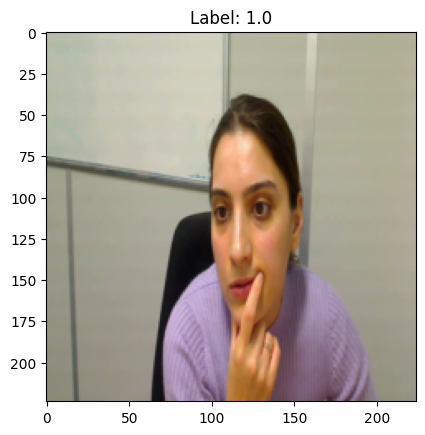

In [6]:
import matplotlib.pyplot as plt

# Take the first image and label
image = x[0]  # Tensor: [3, 224, 224]
label = y[0].item()

# Convert to HWC format for plotting
image = image.permute(1, 2, 0)  # Now [224, 224, 3]
image = image.numpy()  # Convert to numpy

# Denormalize (reverse the transform)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image = std * image + mean
image = image.clip(0, 1)  # Keep in valid range

# Plot
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis("on")
plt.show()

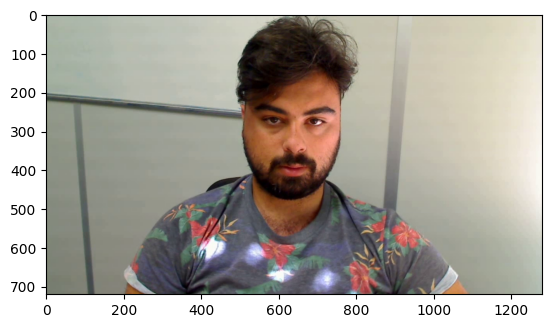

In [7]:
import matplotlib.pyplot as plt

# Load and display the image
img_path = "/mnt/data/StressID-img-data/no-stress/y8c3/breathing/frame_0497.png"
image = plt.imread(img_path)  # Loads image directly
plt.imshow(image)
plt.axis("on")
plt.show()   


In [10]:
train_data.df["str-label"].value_counts("%")

str-label
no-stress    0.571039
stress       0.428961
Name: proportion, dtype: float64